# Advanced Cricket Match Analysis

This notebook fetches match data from Cricbuzz and generates comprehensive visualizations to analyze the match performance.

In [74]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 7]

## 1. Fetch Data

In [75]:
MATCH_ID = 117413
URL_INNINGS_1 = f"https://www.cricbuzz.com/api/mcenter/{MATCH_ID}/full-commentary/1"
URL_INNINGS_2 = f"https://www.cricbuzz.com/api/mcenter/{MATCH_ID}/full-commentary/2"
FILE_INNINGS_1 = "innings_1.json"
FILE_INNINGS_2 = "innings_2.json"

def fetch_and_save(url, filename):
    try:
        print(f"Fetching {url}...")
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        with open(filename, 'w') as f:
            json.dump(data, f, indent=4)
        print(f"Saved to {filename}")
        return data
    except Exception as e:
        print(f"Error: {e}")
        return None

data_1 = fetch_and_save(URL_INNINGS_1, FILE_INNINGS_1)
data_2 = fetch_and_save(URL_INNINGS_2, FILE_INNINGS_2)

Fetching https://www.cricbuzz.com/api/mcenter/117413/full-commentary/1...
Saved to innings_1.json
Fetching https://www.cricbuzz.com/api/mcenter/117413/full-commentary/2...
Saved to innings_2.json


## 2. Parse Data
We extract ball-by-ball data including real player names from the commentary.

In [76]:
def parse_innings(data, innings_label):
    try:
        comm_list = []
        if 'commentary' in data:
            for item in data['commentary']:
                if 'commentaryList' in item:
                    comm_list.extend(item['commentaryList'])
        
        if not comm_list:
            print(f"No commentary list found for {innings_label}")
            return pd.DataFrame()

        # Sort by timestamp to ensure chronological order (oldest first)
        comm_list.sort(key=lambda x: x.get('timestamp', 0))

        records = []
        
        for event in comm_list:
            # Filter out non-ball events
            if 'overNumber' not in event:
                continue
                
            over_str = str(event.get('overNumber', ''))
            if not over_str:
                continue
                
            try:
                over_parts = over_str.split('.')
                over = int(over_parts[0]) + 1
                ball = int(over_parts[1])
            except:
                continue

            # Extract Player Names
            batsman = event.get('batsmanStriker', {}).get('batName', 'Unknown Batter')
            bowler = event.get('bowlerStriker', {}).get('bowlName', 'Unknown Bowler')
            
            # Extract Runs
            total_runs_event = event.get('totalRuns', 0)
            bat_runs = event.get('legalRuns', 0)
            extras = total_runs_event - bat_runs
            
            # Wickets
            is_wicket = 0
            wicket_type = None
            event_tags = event.get('event', '')
            if 'WICKET' in event_tags:
                is_wicket = 1
                wicket_type = 'Wicket'
            
            # Cumulative Score
            current_score = event.get('batTeamScore', 0)
            
            records.append({
                'Innings': innings_label,
                'Over': over,
                'Ball': ball,
                'Runs': bat_runs,
                'Extras': extras,
                'Total': total_runs_event,
                'Cumulative': current_score,
                'Wicket': is_wicket,
                'WicketType': wicket_type,
                'Batsman': batsman,
                'Bowler': bowler
            })

        return pd.DataFrame(records)

    except Exception as e:
        print(f"Error parsing {innings_label}: {e}")
        return pd.DataFrame()

df1 = parse_innings(data_1, 'Innings 1')
df2 = parse_innings(data_2, 'Innings 2')

print("Innings 1 Data Head:")
print(df1.head())
print("\nInnings 1 Batsmen:", df1['Batsman'].unique())
print("\nInnings 2 Batsmen:", df2['Batsman'].unique())

Innings 1 Data Head:
     Innings  Over  Ball  Runs  Extras  Total  Cumulative  Wicket WicketType  \
0  Innings 1     1     1     1       0      1           1       0       None   
1  Innings 1     1     2     4       0      4           5       0       None   
2  Innings 1     1     3     0       0      0           5       1     Wicket   
3  Innings 1     1     4     1       0      1           6       0       None   
4  Innings 1     1     5     0       0      0           6       0       None   

            Batsman       Bowler  
0   Abhishek Sharma  Lungi Ngidi  
1      Shubman Gill  Lungi Ngidi  
2      Shubman Gill  Lungi Ngidi  
3  Suryakumar Yadav  Lungi Ngidi  
4   Abhishek Sharma  Lungi Ngidi  

Innings 1 Batsmen: ['Abhishek Sharma' 'Shubman Gill' 'Suryakumar Yadav' 'Tilak Varma'
 'Axar Patel' 'Hardik Pandya' 'Shivam Dube' 'Jitesh Sharma']

Innings 2 Batsmen: ['Quinton de Kock' 'Tristan Stubbs' 'Aiden Markram' 'Stubbs'
 'Dewald Brevis' 'David Miller' 'Donovan Ferreira' 'Marco J

## 3. Visualizations

### 1. Manhattan Chart (Innings 1)

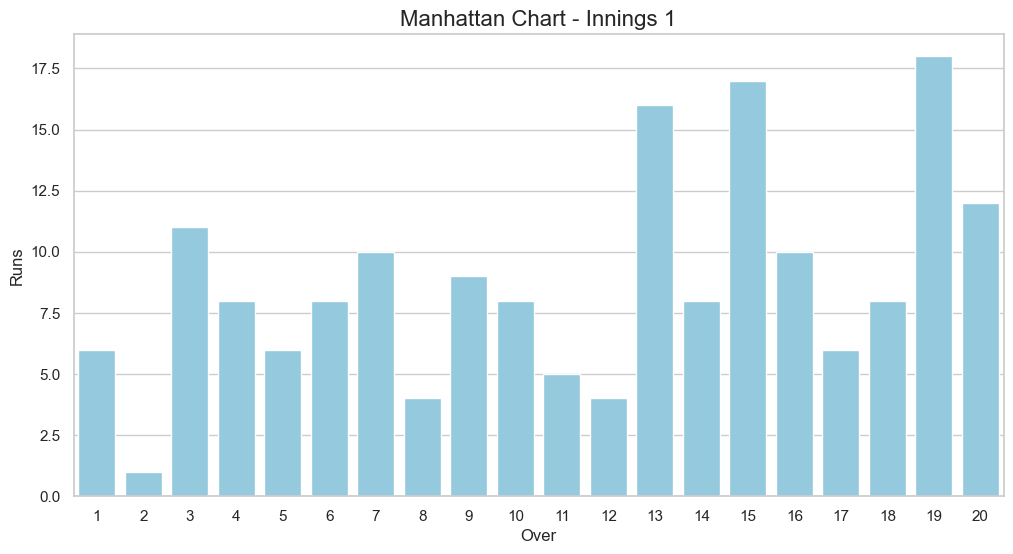

In [77]:
if not df1.empty:
    over_data1 = df1.groupby('Over')['Total'].sum().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(data=over_data1, x='Over', y='Total', color='skyblue')
    plt.title('Manhattan Chart - Innings 1', fontsize=16)
    plt.ylabel('Runs')
    plt.show()

### 2. Manhattan Chart (Innings 2)

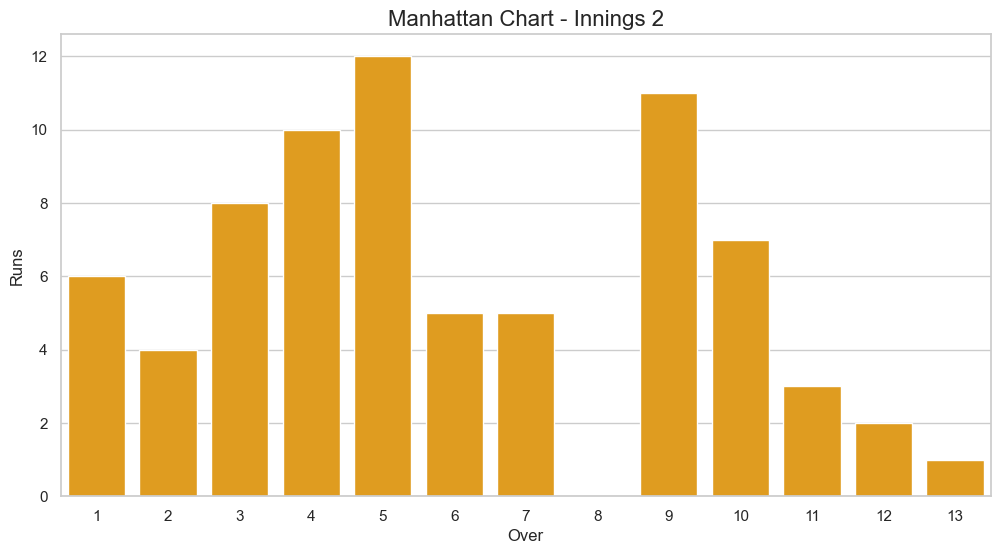

In [78]:
if not df2.empty:
    over_data2 = df2.groupby('Over')['Total'].sum().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(data=over_data2, x='Over', y='Total', color='orange')
    plt.title('Manhattan Chart - Innings 2', fontsize=16)
    plt.ylabel('Runs')
    plt.show()

### 3. Worm Chart (Comparison)

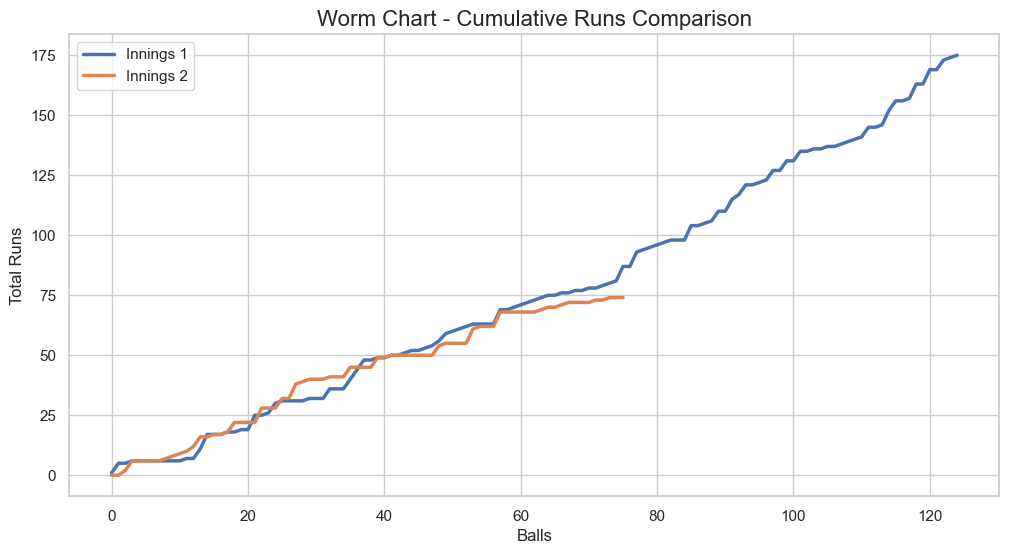

In [79]:
plt.figure(figsize=(12, 6))
if not df1.empty:
    sns.lineplot(data=df1, x=df1.index, y='Cumulative', label='Innings 1', linewidth=2.5)
if not df2.empty:
    sns.lineplot(data=df2, x=df2.index, y='Cumulative', label='Innings 2', linewidth=2.5)
plt.title('Worm Chart - Cumulative Runs Comparison', fontsize=16)
plt.xlabel('Balls')
plt.ylabel('Total Runs')
plt.legend()
plt.show()

### 4. Run Rate Comparison

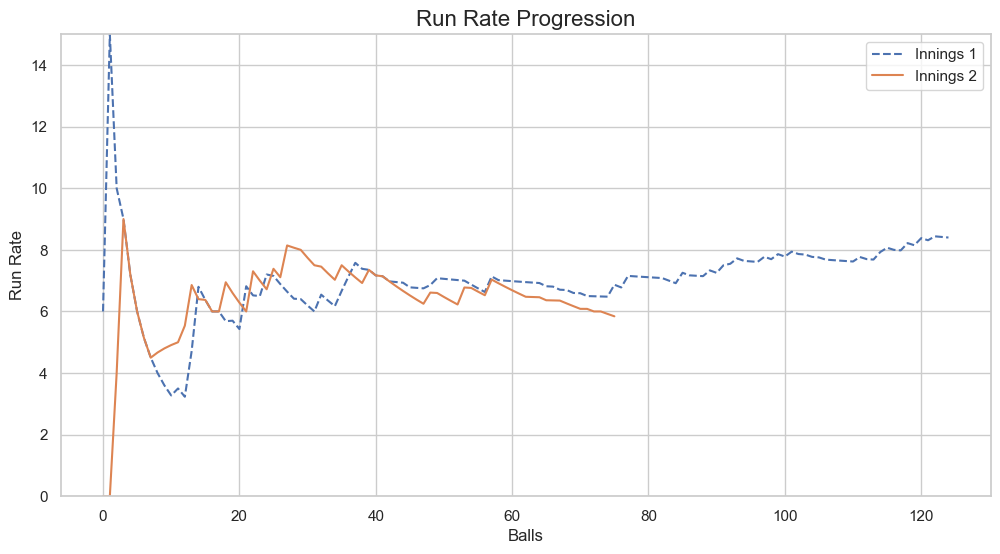

In [80]:
plt.figure(figsize=(12, 6))
if not df1.empty:
    df1['RunRate'] = df1['Cumulative'] / (df1.index + 1) * 6
    sns.lineplot(data=df1, x=df1.index, y='RunRate', label='Innings 1', linestyle='--')
if not df2.empty:
    df2['RunRate'] = df2['Cumulative'] / (df2.index + 1) * 6
    sns.lineplot(data=df2, x=df2.index, y='RunRate', label='Innings 2', linestyle='-')
plt.title('Run Rate Progression', fontsize=16)
plt.xlabel('Balls')
plt.ylabel('Run Rate')
plt.ylim(0, 15)
plt.legend()
plt.show()

### 5. Run Rate Distribution (Histogram)

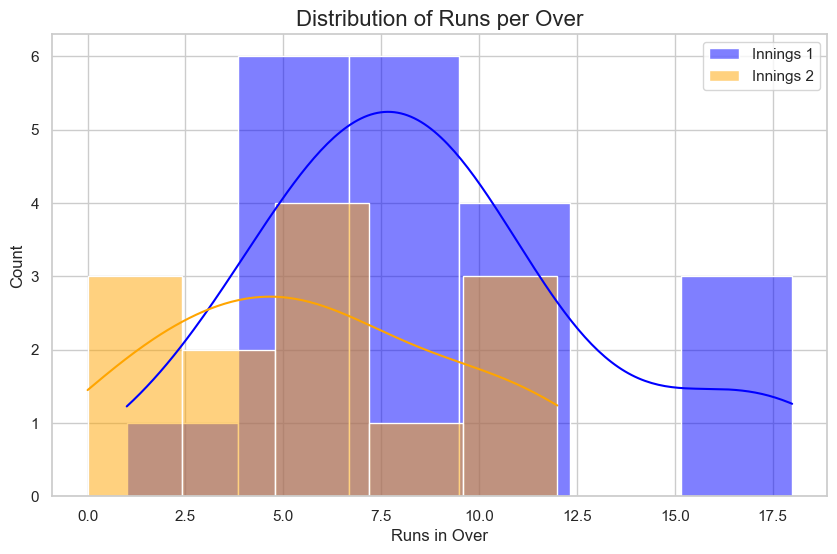

In [81]:
plt.figure(figsize=(10, 6))
if not df1.empty:
    sns.histplot(over_data1['Total'], color='blue', label='Innings 1', kde=True, alpha=0.5)
if not df2.empty:
    sns.histplot(over_data2['Total'], color='orange', label='Innings 2', kde=True, alpha=0.5)
plt.title('Distribution of Runs per Over', fontsize=16)
plt.xlabel('Runs in Over')
plt.legend()
plt.show()

### 6. Fall of Wickets (Innings 1)

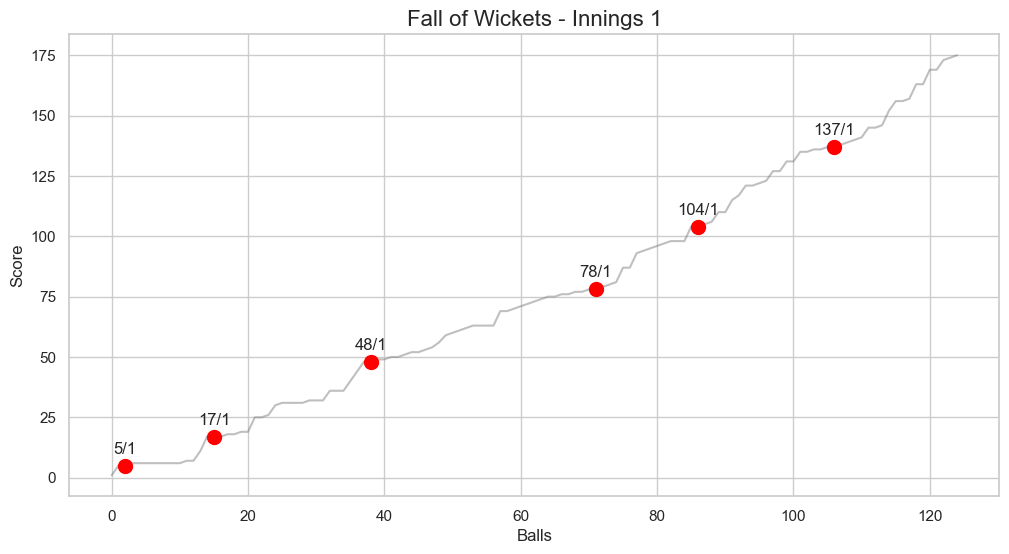

In [82]:
if not df1.empty:
    wickets1 = df1[df1['Wicket'] == 1]
    plt.figure(figsize=(12, 6))
    plt.plot(df1.index, df1['Cumulative'], color='gray', alpha=0.5)
    plt.scatter(wickets1.index, wickets1['Cumulative'], color='red', s=100, zorder=5)
    for i, row in wickets1.iterrows():
        plt.text(i, row['Cumulative']+5, f"{row['Cumulative']}/{int(row['Wicket'])}", ha='center')
    plt.title('Fall of Wickets - Innings 1', fontsize=16)
    plt.xlabel('Balls')
    plt.ylabel('Score')
    plt.show()

### 7. Fall of Wickets (Innings 2)

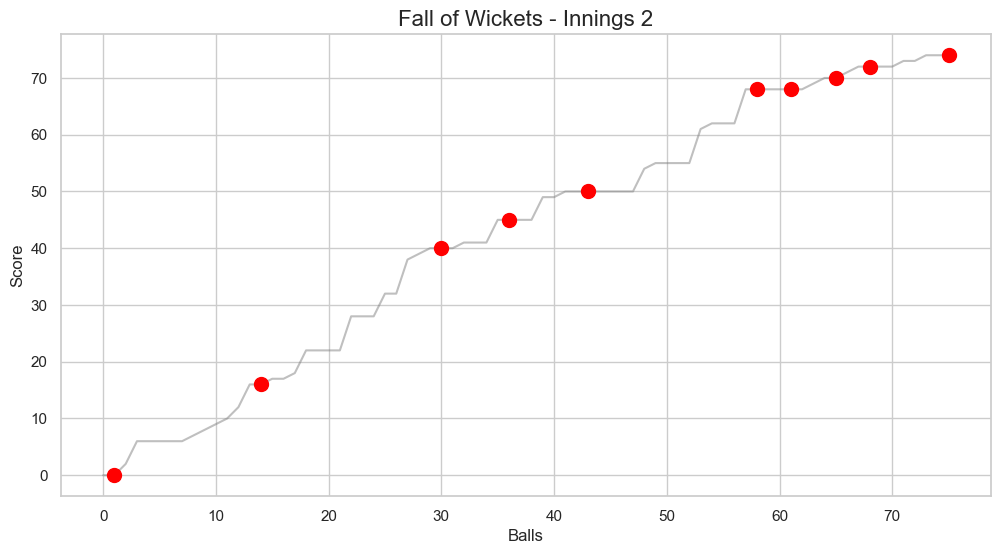

In [83]:
if not df2.empty:
    wickets2 = df2[df2['Wicket'] == 1]
    plt.figure(figsize=(12, 6))
    plt.plot(df2.index, df2['Cumulative'], color='gray', alpha=0.5)
    plt.scatter(wickets2.index, wickets2['Cumulative'], color='red', s=100, zorder=5)
    plt.title('Fall of Wickets - Innings 2', fontsize=16)
    plt.xlabel('Balls')
    plt.ylabel('Score')
    plt.show()

### 8. Extras Breakdown

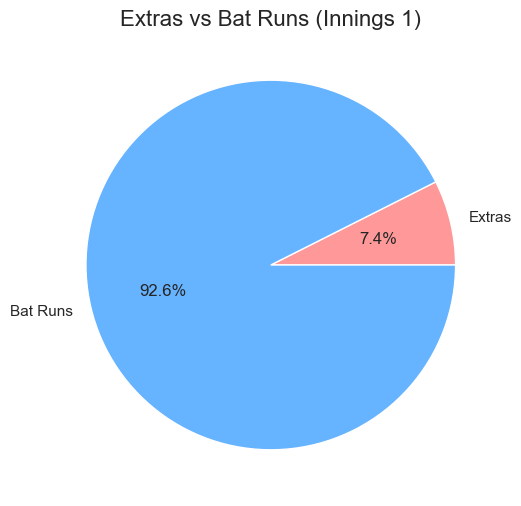

In [84]:
if not df1.empty:
    extras_count = df1['Extras'].sum()
    labels = ['Extras', 'Bat Runs']
    sizes = [extras_count, df1['Runs'].sum()]

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    plt.title('Extras vs Bat Runs (Innings 1)', fontsize=16)
    plt.show()

### 9. Batsman Contribution (Innings 1)

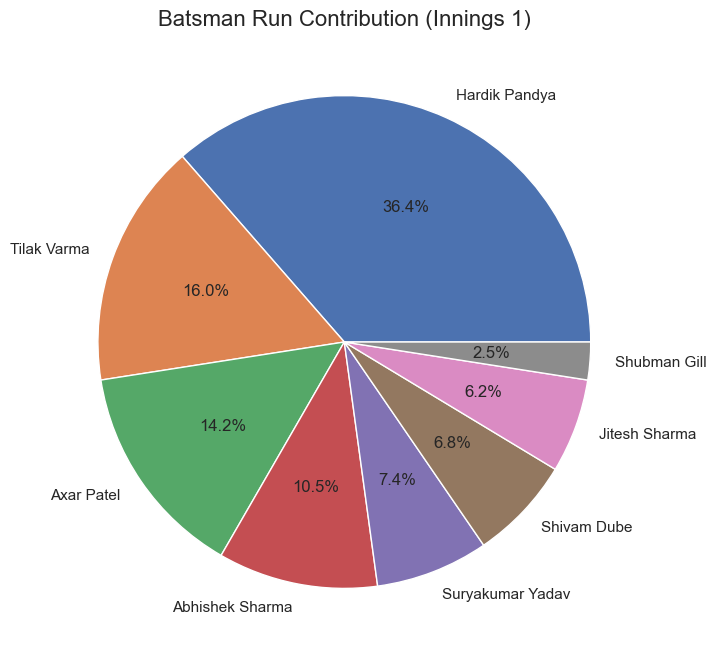

In [85]:
if not df1.empty:
    bat_stats = df1.groupby('Batsman')['Runs'].sum().sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    plt.pie(bat_stats, labels=bat_stats.index, autopct='%1.1f%%')
    plt.title('Batsman Run Contribution (Innings 1)', fontsize=16)
    plt.show()

### Batsman Contribution - Innings 2

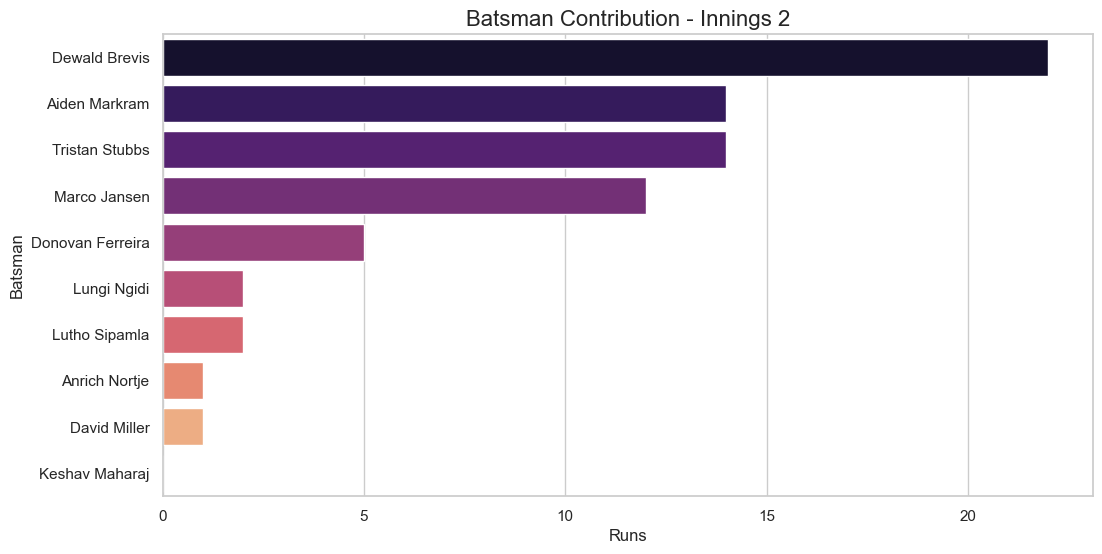

In [86]:

if not df2.empty:
    bat_stats2 = df2.groupby('Batsman')['Runs'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=bat_stats2.values, y=bat_stats2.index, hue=bat_stats2.index, palette='magma', legend=False)
    plt.title('Batsman Contribution - Innings 2', fontsize=16)
    plt.xlabel('Runs')
    plt.show()


### 10. Bowler Performance (Wickets)

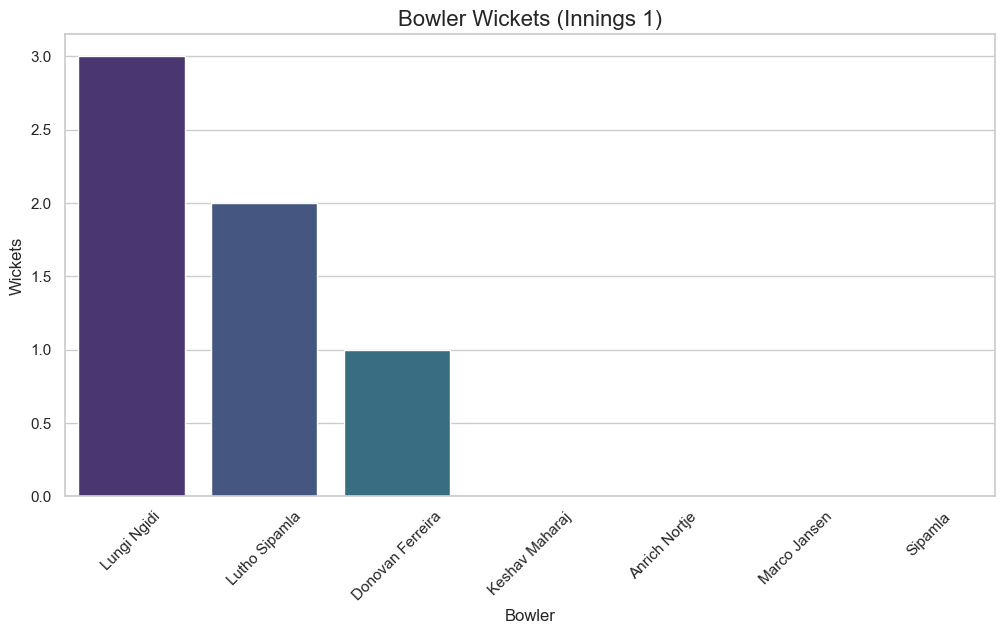

In [87]:
if not df1.empty:
    bowl_stats = df1.groupby('Bowler')['Wicket'].sum().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=bowl_stats.index, y=bowl_stats.values, hue=bowl_stats.index, palette='viridis', legend=False)
    plt.title('Bowler Wickets (Innings 1)', fontsize=16)
    plt.ylabel('Wickets')
    plt.xticks(rotation=45)
    plt.show()

### Bowler Performance - Innings 2

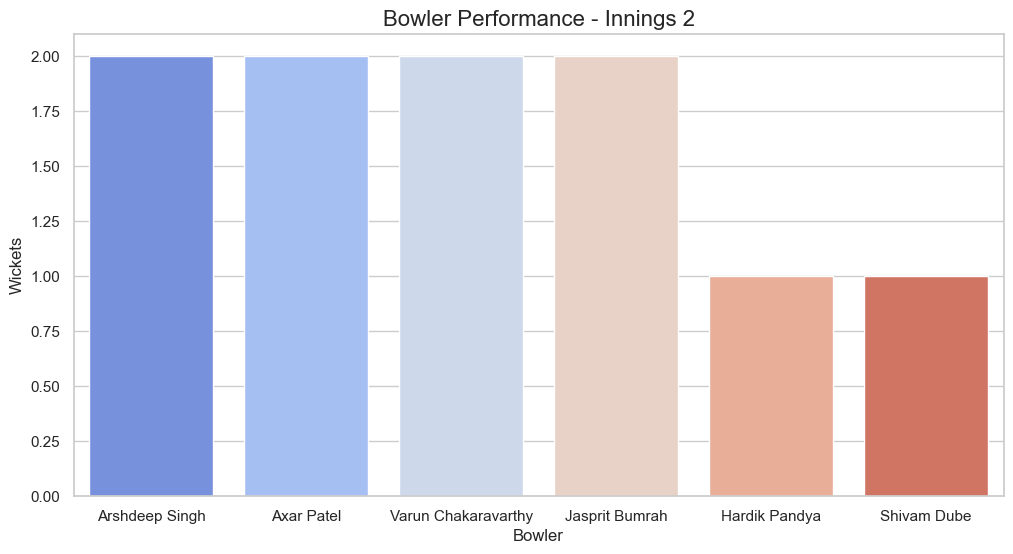

In [88]:

if not df2.empty:
    bowl_stats2 = df2[df2['Wicket'] == 1]['Bowler'].value_counts().head(10)
    if not bowl_stats2.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(x=bowl_stats2.index, y=bowl_stats2.values, hue=bowl_stats2.index, palette='coolwarm', legend=False)
        plt.title('Bowler Performance - Innings 2', fontsize=16)
        plt.ylabel('Wickets')
        plt.show()
    else:
        print("No wickets taken in Innings 2")


### 11. Boundary Analysis

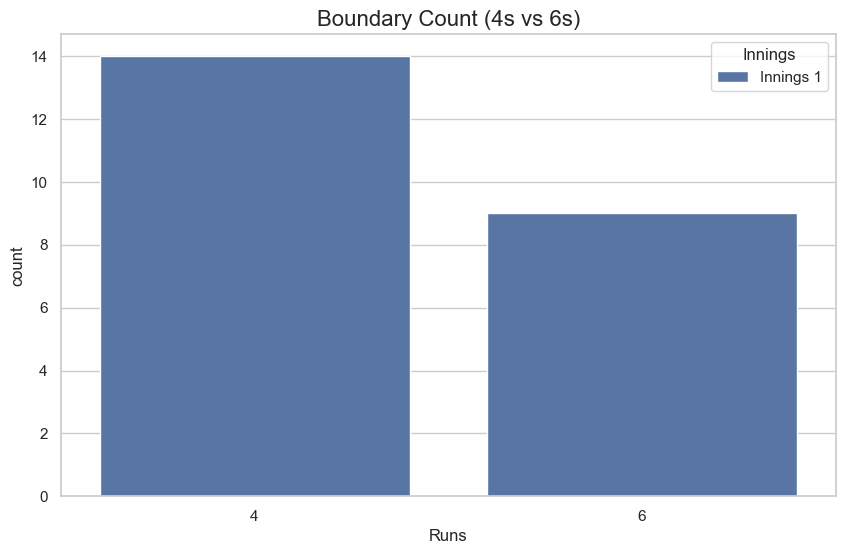

In [89]:
if not df1.empty:
    boundaries = df1[df1['Runs'].isin([4, 6])]
    plt.figure(figsize=(10, 6))
    sns.countplot(data=boundaries, x='Runs', hue='Innings')
    plt.title('Boundary Count (4s vs 6s)', fontsize=16)
    plt.show()

### Boundary Analysis (Innings 2)

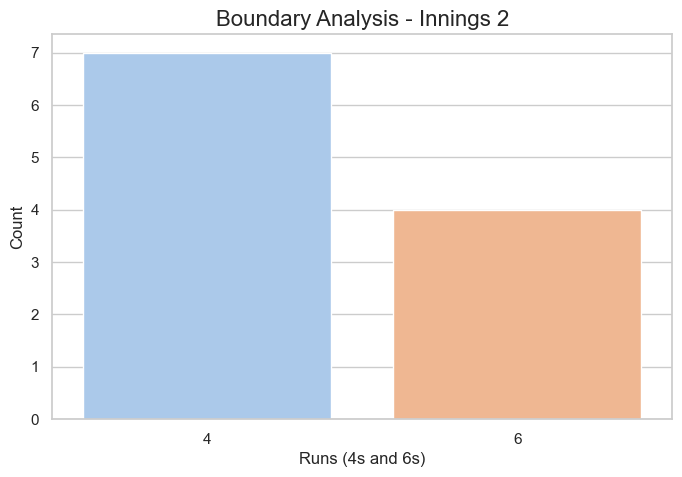

In [90]:

if not df2.empty:
    boundaries2 = df2[df2['Runs'].isin([4, 6])]['Runs'].value_counts().sort_index()
    if not boundaries2.empty:
        plt.figure(figsize=(8, 5))
        sns.barplot(x=boundaries2.index, y=boundaries2.values, hue=boundaries2.index, palette='pastel', legend=False)
        plt.title('Boundary Analysis - Innings 2', fontsize=16)
        plt.xlabel('Runs (4s and 6s)')
        plt.ylabel('Count')
        plt.show()
    else:
        print("No boundaries in Innings 2")
